# Domain analysis

In [1]:
import pickle
import sys, os
sys.path.append("/Users/chilpert/Work/pyproteinsExt/src")
sys.path.append("/Users/chilpert/Work/pyproteins/src")
import pyproteinsExt 
import pyproteins
import time

In [2]:
def save(data, tag=None):
    saveDir="/Volumes/arwen/mobi/group/NOX_CH/pickle_saved"
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fTag = "NOX_annotation_" + tag + "_" if tag else "NOX_annotation_"
    fSerialDump = fTag + timestr + ".pickle"
    with open(saveDir + '/' + fSerialDump, 'wb') as f:
        pickle.dump(data, f)
    print('data structure saved to', saveDir + '/' + fSerialDump)

def load(fileName):
    saveDir="/Volumes/arwen/mobi/group/NOX_CH/pickle_saved"
    d = pickle.load( open(saveDir + "/" + fileName, "rb" ) )
    print("restore a annotated container of ", len(d), "elements")
    return d

##### Load full Pfam annotation

In [12]:
data=load("NOX_annotation_fullPfam_filteredDomains_20190513-123216.pickle")

restore a annotated container of  785 elements


##### Parse data 

In [16]:
def parse_data(data): 
    '''Return dictionnary with domain as key and list of proteins that contains this domain as value'''
    dic_domain={}
    for protein in data :
        for domain in data[protein]['hmmr']:
            if domain in dic_domain:
                dic_domain[domain].append(protein)
            else:     
                dic_domain[domain]=[protein]
    return(dic_domain)       

def simplify_data(data):
    dic_protein={}
    for protein in data : 
        dic_protein[protein]=list(data[protein]['hmmr'].keys())
    return dic_protein    

def assemble_domains_with_same_proteins(dic_domain):
    dic_prot={}
    for d in dic_domain:
        dic_domain[d].sort()
        prots=",".join(dic_domain[d])
        if not prots in dic_prot: 
            dic_prot[prots]=set()
        dic_prot[prots].add(d)
    new_dic_domain={}    
    for p in dic_prot: 
        doms=",".join(dic_prot[p])
        new_dic_domain[doms]=p.split(",")
    return new_dic_domain    

In [17]:
from collections import OrderedDict
dic_domain=parse_data(data)
ordered_dic_domain=OrderedDict(sorted(dic_domain.items(),key=lambda kv: len(kv[1]),reverse=True))
decrease_dic_domain=OrderedDict(sorted(dic_domain.items(),key=lambda kv: len(kv[1]),reverse=False))
dic_protein=simplify_data(data)
ordered_dic_protein=OrderedDict(sorted(dic_protein.items(),key=lambda kv: len(kv[1]),reverse=True))
assemble_dic_domain=assemble_domains_with_same_proteins(dic_domain)

In [60]:
import matplotlib.pyplot as plt
import numpy as np

In [40]:
height=[len(ordered_dic_domain[d]) for d in ordered_dic_domain]
bars=tuple(ordered_dic_domain.keys())
height=height[:15][::-1]
bars=bars[:15][::-1]

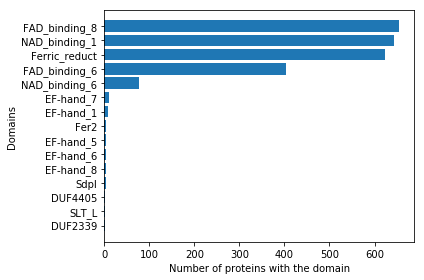

In [41]:
plt.barh(bars,height)
plt.xlabel("Number of proteins with the domain")
plt.ylabel("Domains")
plt.tight_layout()
plt.savefig("/Users/chilpert/Work/NOX_visu/domains_proteins.pdf",format="pdf")

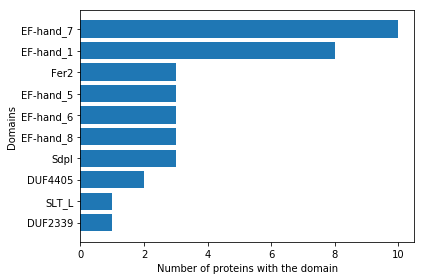

In [42]:
no_core_domain_height=height[:-5]
no_core_domain_bars=bars[:-5]
no_core_domain_ypos=np.arange(len(no_core_domain_bars))
plt.barh(no_core_domain_ypos,no_core_domain_height)
plt.yticks(no_core_domain_ypos,no_core_domain_bars)
plt.xlabel("Number of proteins with the domain")
plt.ylabel("Domains")
plt.tight_layout()
plt.savefig("/Users/chilpert/Work/NOX_visu/domains_proteins_no_core.svg",format="svg")
plt.savefig("/Users/chilpert/Work/NOX_visu/domains_proteins_no_core.pdf",format="pdf")

In [43]:
dic_nb_domain={}
for p in data : 
    nb_domain=len(data[p]['hmmr'].keys())
    if nb_domain not in dic_nb_domain : 
        dic_nb_domain[nb_domain]=0
    dic_nb_domain[nb_domain]+=1    

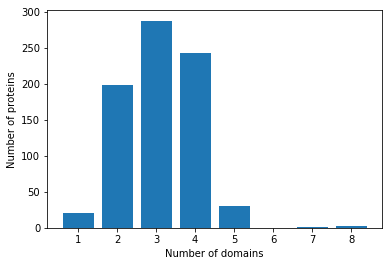

In [44]:
x=list(dic_nb_domain.keys())
y=list(dic_nb_domain.values())
plt.bar(x,y)
plt.xlabel("Number of domains")
plt.ylabel("Number of proteins")
plt.savefig("/Users/chilpert/Work/NOX_visu/distrib_nb_domains.svg",format="svg")
plt.savefig("/Users/chilpert/Work/NOX_visu/distrib_nb_domains.pdf",format="pdf")

#### Create, browse and modify ete3 tree 

In [23]:
from ete3 import NCBITaxa
from ete3 import Tree
ncbi = NCBITaxa()

* Create tree from all taxids 

In [6]:
all_taxids=set([data[p]['taxid'] for p in data])
print(len(all_taxids))
all_tree=ncbi.get_topology(list(all_taxids))

649


* Create dictionnary to complete ete3 tree  
Dic_all_taxids :   
    Key : taxid   
    Value : dictionnary {'domains' : set of associated domains, 'proteins':set of associated proteins}

In [77]:
core_domain=["NAD_binding_1","FAD_binding_8","Ferric_reduct","FAD_binding_6","NAD_binding_6"]
dic_all_taxids={}
all_domains=set()
for p in data:
    taxid=data[p]['taxid']
    domains=data[p]['hmmr']
    domains_to_add=set()
    for d in domains: 
        all_domains.add(d)
    if taxid not in dic_all_taxids: 
        dic_all_taxids[taxid]={'domains':set(),'proteins':set()}
    dic_all_taxids[taxid]['domains'].update(domains_to_add)    
    dic_all_taxids[taxid]['proteins'].add(p)

* Complete Tree object with list of domains and proteins for each node

In [8]:
node_list=[]
for n in all_tree.traverse('postorder'):
    node_list.append(n)
    n.sameDomainNode=set()
    #print(n.name,n.sci_name,n.rank)
    if n.name in dic_all_taxids:
        n.domains=dic_all_taxids[n.name]['domains']   
        n.proteins=dic_all_taxids[n.name]['proteins']
    else:
        n.domains=set()
        n.proteins=set()
    if n.get_descendants():
        for child in n.children: 
            n.domains.update(child.domains)    
            n.proteins.update(child.proteins)

* Complete Tree object with list of nodes with same domains for each node

In [9]:
c=0
for i in range(len(node_list)):
    c+=1
    for j in range(i+1,len(node_list)):
        #print(i,j)
        n1=node_list[i]
        n2=node_list[j]
        if len(n1.domains)==len(n2.domains):
            if not n1.domains.difference(n2.domains):
                n1.sameDomainNode.add(n2)
                n2.sameDomainNode.add(n1)       

* Create DomainGroup objects, that contains domains associated with proteins

In [50]:
from statistics import mean
class DomainGroup: 
    def __init__(self,domains,proteins,data):
        self.domains=domains
        self.proteins=proteins
        self.taxids=list(set([data[p]["taxid"] for p in self.proteins]))
        
    def compute_upper_node(self,all_tree):
        if len(self.taxids)==1: 
            self.upper_node=all_tree.search_nodes(name=self.taxids[0])[0]
        else:     
            tree=ncbi.get_topology(self.taxids)
            traverse_generator=tree.traverse()
            self.upper_node=next(traverse_generator)
        
    def compute_mean_max_distance(self):
        self.dists=[]
        tree=ncbi.get_topology(self.taxids)
        if len(self.taxids)==1: 
            self.mean_dist=0
            self.max_dist=0
            return 
        for i in range(len(self.taxids)): 
            for j in range(i+1,len(self.taxids)):
                dist=tree.get_distance(self.taxids[i],self.taxids[j])
                self.dists.append(dist)
        self.mean_dist=mean(self.dists)
        self.max_dist=max(self.dists)

* Compute distance and upper_node for each group of domains.  
Mean distance is the mean distance between each pair of proteins. Max distance is the maximum distance among each pair of proteins. Upper node is the lowest node that gather all proteins

In [51]:
set_DomainGroup=set()
for k in assemble_dic_domain:
    d=DomainGroup(k.split(","),assemble_dic_domain[k],data)
    d.compute_upper_node(all_tree)
    d.compute_mean_max_distance()
    set_DomainGroup.add(d)

* Compute percentage taxonomy.  
It's the percentage of proteins at this taxonomic level that contains the domains. 

In [52]:
for s in set_DomainGroup: 
    n=all_tree.search_nodes(name=s.upper_node.name)[0]
    percent_taxo=len(s.proteins)/len(n.proteins)*100
    s.percent_taxo=percent_taxo

* Save objects

In [53]:
setDomains=set_DomainGroup

In [14]:
import sys
sys.setrecursionlimit(10000)
save(all_tree,"Tree")
sys.setrecursionlimit(3000)

data structure saved to /Volumes/arwen/mobi/group/NOX_CH/pickle_saved/NOX_annotation_Tree_20190510-103656.pickle


data structure saved to /Volumes/arwen/mobi/group/NOX_CH/pickle_saved/NOX_annotation_Tree_20190510-103641.pickle


In [21]:
print(type(all_tree))

<class 'ete3.phylo.phylotree.PhyloNode'>


#### Generate outputs

* Load objects

In [44]:
setDomains=pickle.load(open('/Volumes/arwen/mobi/group/NOX_CH/pickle_saved/domain_groups_20190426-113558.pickle',"rb"))
all_tree=pickle.load(open('/Volumes/arwen/mobi/group/NOX_CH/pickle_saved/ete3_tree_20190426-113558.pickle',"rb"))

* Output names

In [20]:
single_domains_output="/Volumes/arwen/mobi/group/NOX_CH/Domain/domains_stats.tsv"
assemble_domains_output="/Volumes/arwen/mobi/group/NOX_CH/Domain/assembled_domains_stats.tsv"
assemble_domains_by_prot_output="/Volumes/arwen/mobi/group/NOX_CH/Domain/assembled_domains_sort_by_prot_stats.tsv"
proteins_output="/Volumes/arwen/mobi/group/NOX_CH/Domain/proteins_stats.tsv"
by_species_order_prot_output="/Volumes/arwen/mobi/group/NOX_CH/Domain/by_species_prot_order.tsv"
by_species_order_dom_output="/Volumes/arwen/mobi/group/NOX_CH/Domain/by_species_dom_order.tsv"
by_genus_order_prot_output="/Volumes/arwen/mobi/group/NOX_CH/Domain/by_genus_prot_order.tsv"
by_genus_order_dom_output="/Volumes/arwen/mobi/group/NOX_CH/Domain/by_genus_dom_order.tsv"
by_organism_order_prot_output="/Volumes/arwen/mobi/group/NOX_CH/Domain/by_organism_prot_order.tsv"

In [58]:
def write_domains_output(set_domain_groups,domains_output): 
    o=open(domains_output,"w")
    o.write("#Domain(s)\tNumber of associated proteins\tAssociated proteins\tUpper node(taxid)\tUpper node(taxname)\tUpper node(taxrank)\t% taxon\tMean distance\tMax distance\n")
    c=0
    for d in set_domain_groups:
        o.write("%s\t%d\t%s\t%s\t%s\t%s\t%.5f\t%.5f\t%.5f\n" % (",".join(d.domains),len(d.proteins),",".join(d.proteins),d.upper_node.name,d.upper_node.sci_name,d.upper_node.rank,d.percent_taxo,d.mean_dist,d.max_dist))
    o.close()  
    
def write_by_tax_level_output(output,dic_tax_level,tax_level): 
    o=open(output,"w")
    o.write("#Taxo level\tTaxo name\tNumber of proteins\tNumber of domains\tProteins\tDomains\n")
    for tl in dic_tax_level:
        o.write(tax_level+"\t"+tl+"\t"+str(len(dic_tax_level[tl]['proteins']))+"\t"+str(len(dic_tax_level[tl]['domains']))+"\t"+",".join(dic_tax_level[tl]['proteins'])+"\t"+",".join(dic_tax_level[tl]['domains'])+"\n")
    o.close()    

In [59]:
ordered_domain_setDomains=sorted(setDomains,key=lambda d: len(d.domains),reverse=True)
ordered_protein_setDomains=sorted(setDomains,key=lambda d: len(d.proteins),reverse=True)

write_domains_output(ordered_domain_setDomains,assemble_domains_output)
write_domains_output(ordered_protein_setDomains,assemble_domains_by_prot_output)

In [24]:
dic_taxonomy={}
for p in data: 
    taxid=data[p]['taxid']
    taxname=ncbi.get_taxid_translator([taxid])[int(taxid)]
    taxrank=ncbi.get_rank([taxid])[int(taxid)]
    dic_taxonomy[p]={'taxid':taxid,'taxname':taxname,'taxrank':taxrank}

In [28]:
o=open(proteins_output,"w")
o.write("#Protein\tLength\tTaxid\tTaxname\tTaxrank\tNumber of domains\tDomains\n")
for p in ordered_dic_protein: 
    length=data[p]['tmhmm']['Length']
    o.write(p+"\t"+str(length)+"\t"+dic_taxonomy[p]['taxid']+"\t"+dic_taxonomy[p]['taxname']+"\t"+dic_taxonomy[p]['taxrank']+"\t"+str(len(ordered_dic_protein[p]))+"\t"+",".join(ordered_dic_protein[p])+"\n")
o.close()

In [62]:
def get_tax_level(taxid,tax_level): 
    taxid=int(taxid)
    rank=ncbi.get_rank([taxid])[taxid]
    if rank == tax_level : 
        taxname=ncbi.get_taxid_translator([taxid])[taxid]
        return(taxname)
    else:
        lineage=ncbi.get_lineage(taxid)
        ranks=ncbi.get_rank(lineage)
        specie=[taxid for taxid in ranks if ranks[taxid]==tax_level]
        if specie : 
            taxname=ncbi.get_taxid_translator(specie)[specie[0]]
            return(taxname)

In [63]:
def complete_dic_tax_level(tax_level,dic,prot,dic_prot):
    if tax_level: 
        if tax_level not in dic: 
            dic[tax_level]={'proteins':set(),'domains':set()}
        dic[tax_level]['proteins'].add(prot)
        dic[tax_level]['domains'].update(dic_prot[prot])
    return dic     

In [93]:
dic_specie={}
dic_genus={}
dic_organism={}
for p in dic_taxonomy: 
    organism=dic_taxonomy[p]['taxname']
    specie=get_tax_level(dic_taxonomy[p]['taxid'],"species")
    genus=get_tax_level(dic_taxonomy[p]['taxid'],"genus")
    dic_genus=complete_dic_tax_level(genus,dic_genus,p,dic_protein)
    dic_organism=complete_dic_tax_level(organism,dic_organism,p,dic_protein)
    if specie: 
        if specie not in dic_specie : 
            dic_specie[specie]={'proteins':set(),'domains':set()}
        dic_specie[specie]['proteins'].add(p)
        dic_specie[specie]['domains'].update(dic_protein[p])  

ordered_prot_dic_species=OrderedDict(sorted(dic_specie.items(),key=lambda kv: len(kv[1]['proteins']),reverse=True))
ordered_domain_dic_species=OrderedDict(sorted(dic_specie.items(),key=lambda kv: len(kv[1]['domains']),reverse=True))
ordered_prot_dic_genus=OrderedDict(sorted(dic_genus.items(),key=lambda kv: len(kv[1]['proteins']),reverse=True))
ordered_domain_dic_genus=OrderedDict(sorted(dic_genus.items(),key=lambda kv: len(kv[1]['domains']),reverse=True))
ordered_prot_dic_organism=OrderedDict(sorted(dic_organism.items(),key=lambda kv: len(kv[1]['proteins']),reverse=True))

In [94]:
#By species
write_by_tax_level_output(by_species_order_prot_output,ordered_prot_dic_species,"species")
write_by_tax_level_output(by_species_order_dom_output,ordered_domain_dic_species,"species")
#By genus 
write_by_tax_level_output(by_genus_order_prot_output,ordered_prot_dic_genus,"genus")
write_by_tax_level_output(by_genus_order_dom_output,ordered_domain_dic_genus,"genus")
#By organism 
write_by_tax_level_output(by_organism_order_prot_output,ordered_prot_dic_organism,"organism")

In [96]:
print(data['tr|A0A355CGZ4|A0A355CGZ4_9CYAN']['hmmr'].keys())

dict_keys(['NAD_binding_6', 'FAD_binding_8', 'Ferric_reduct', 'EF-hand_7', 'EF-hand_1'])


#### Most abondant species

In [67]:
x=[]
y=[]
for sp in ordered_prot_dic_species: 
    x.append(len(ordered_prot_dic_species[sp]['proteins']))
    y.append(sp)   
x=x[:5][::-1]
y=y[:5][::-1]    

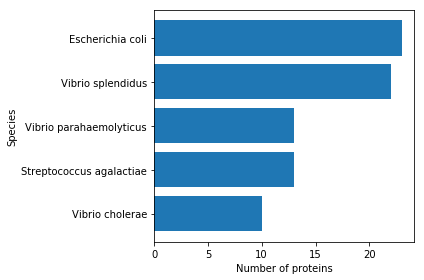

In [68]:
plt.barh(y,x)
plt.ylabel("Species")
plt.xlabel("Number of proteins")
plt.tight_layout()
plt.savefig("/Users/chilpert/Work/NOX_visu/species_most_abondant.svg",format="svg")
plt.savefig("/Users/chilpert/Work/NOX_visu/species_most_abondant.pdf",format="pdf")

#### Most abundant genus

In [69]:
x=[]
y=[]
for sp in ordered_prot_dic_genus: 
    x.append(len(ordered_prot_dic_genus[sp]['proteins']))
    y.append(sp) 
print(x)    
x=x[:6][::-1]
y=y[:6][::-1]

[120, 95, 23, 18, 18, 16, 15, 14, 11, 9, 9, 8, 8, 7, 7, 7, 7, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


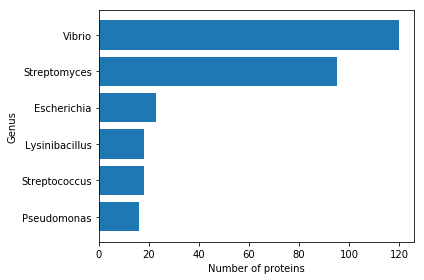

In [70]:
plt.barh(y,x)
plt.ylabel("Genus")
plt.xlabel("Number of proteins")
plt.tight_layout()
plt.savefig("/Users/chilpert/Work/NOX_visu/genus_most_abondant.svg",format="svg")
plt.savefig("/Users/chilpert/Work/NOX_visu/genus_most_abondant.pdf",format="pdf")

#### Distribution of number of proteins among species

In [71]:
dic_nb_proteins={}
for sp in ordered_prot_dic_species: 
    nb_proteins=len(ordered_prot_dic_species[sp]['proteins'])
    if nb_proteins not in dic_nb_proteins: 
        dic_nb_proteins[nb_proteins]=0 
    dic_nb_proteins[nb_proteins]+=1

In [72]:
x=list(dic_nb_proteins.keys())
y=list(dic_nb_proteins.values())

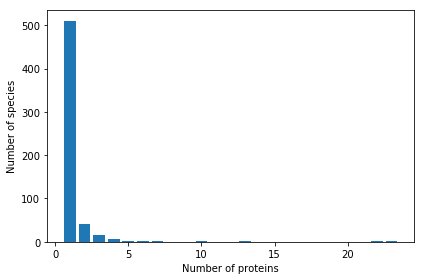

In [73]:
plt.bar(x,y)
plt.xlabel("Number of proteins")
plt.ylabel("Number of species")
plt.tight_layout()
plt.savefig("/Users/chilpert/Work/NOX_visu/distrib_nb_proteins_species.svg",format="svg")
plt.savefig("/Users/chilpert/Work/NOX_visu/distrib_nb_proteins_species.pdf",format="pdf")

#### Report same nodes

In [74]:
node_browse=set()
clusters_node=[]
for n1 in all_tree.traverse(): 
    #print("N1",n1.name,n1.sci_name)
    if n1.name not in node_browse: 
        #print("BROWSE")
        set_nodes=set()
        set_nodes.add(n1)
        node_browse.add(n1.name)
        for n2 in n1.sameDomainNode: 
            node_browse.add(n2.name)
            #print("N2",n2.name,n2.sci_name)
            set_nodes.add(n2)
        clusters_node.append(set_nodes)

In [75]:
c=0
for clust in clusters_node: 
    if len(clust)>1: 
        c+=1

In [76]:
print(str(len(clusters_node))+" clusters has been found. "+str(c)+" are not singletons.")

1 clusters has been found. 1 are not singletons.


* See at which level domains remain the same

In [77]:
browse=set()
highest_conserve_nodes=set()
for n in all_tree.traverse():
    #print(n.name,n.sci_name,n.rank)
    desc=set(n.get_descendants())
    print(n.name,desc)
    if n not in browse and desc and desc.issubset(n.sameDomainNode):
        browse.update(desc)
        highest_conserve_nodes.add(n)
    browse.add(n)    
    

1 {PhyloTree node '1227268' (0x111f5808), PhyloTree node '186802' (0x1118b008), PhyloTree node '1797569' (0x11188808), PhyloTree node '1975705' (0x1118a00f), PhyloTree node '2067669' (0x1118900f), PhyloTree node '1855336' (0x1116d00f), PhyloTree node '875932' (0x1118a016), PhyloTree node '1855348' (0x1116d016), PhyloTree node '1001989' (0x111f5816), PhyloTree node '85007' (-0x7fffffffeee4dfe7), PhyloTree node '589865' (0x111f4016), PhyloTree node '28211' (0x111f401d), PhyloTree node '2053569' (0x1118881d), PhyloTree node '253239' (0x1118b01d), PhyloTree node '562' (0x111f581d), PhyloTree node '2024861' (0x1118a01d), PhyloTree node '1855351' (0x1116d01d), PhyloTree node '656441' (0x111b201d), PhyloTree node '1978231' (0x1116d024), PhyloTree node '265668' (0x11188824), PhyloTree node '388408' (0x1118b024), PhyloTree node '1522760' (-0x7fffffffeee4dfd9), PhyloTree node '114090' (0x1118a024), PhyloTree node '41295' (0x111f402b), PhyloTree node '1764569' (0x1118902b), PhyloTree node '205357

1280998 set()
1281024 set()
656441 set()
1268986 set()
585056 set()
439855 set()
1169330 set()
1169354 set()
1169355 set()
749527 set()
749549 set()
1144320 set()
69393 set()
1124983 set()
220664 set()
696485 {PhyloTree node '1229493' (0x111b2108)}
766224 set()
190895 set()
670 {PhyloTree node '1238219' (-0x7fffffffeee501d2), PhyloTree node '1338034' (0x111b0bef), PhyloTree node '223926' (0x111b210f), PhyloTree node '1288779' (0x111afa1d), PhyloTree node '419109' (0x11189bbe)}
663 set()
669 {PhyloTree node '673519' (0x11188378)}
680 set()
2047825 set()
50719 set()
1191300 set()
412614 set()
345072 set()
345074 set()
579112 set()
686 {PhyloTree node '243277' (-0x7fffffffeee75007), PhyloTree node '417400' (0x1118afcc)}
216895 set()
196600 set()
671074 set()
617140 set()
314291 set()
1191305 set()
312309 set()
388396 set()
589865 set()
1385624 set()
1805128 set()
419481 set()
1797238 set()
290397 set()
1254432 set()
1121915 set()
1811718 set()
1499107 set()
690850 set()
1262666 set()
1065

In [78]:
print(len(highest_conserve_nodes))

1


* Generate outputs

In [79]:
all_clusters="/Volumes/arwen/mobi/group/NOX_CH/Domain/all_cluster_nodes.tsv"
all_clusters_nodes_separated="/Volumes/arwen/mobi/group/NOX_CH/Domain/all_cluster_nodes_oneline_per_node.tsv"
all_clusters_no_singletons="/Volumes/arwen/mobi/group/NOX_CH/Domain/all_cluster_nodes_no_singletons.tsv"
all_clusters_no_singletons_nodes_separated="/Volumes/arwen/mobi/group/NOX_CH/Domain/all_cluster_nodes_no_singletons_oneline_per_node.tsv"
highest_conserve_nodes_out="/Volumes/arwen/mobi/group/NOX_CH/Domain/highest_conserve_nodes.tsv"

In [80]:
o=open(all_clusters,"w")
o2=open(all_clusters_no_singletons,"w")
o.write("#Cluster\tCluster size\tNode taxid(s)\tNode name(s)\tNode rank(s)\tNumber of domains\tList of domains\n")
clust_nb=0
for clust in clusters_node : 
    clust_nb+=1
    taxids=[n.name for n in clust]
    names=[n.sci_name for n in clust]
    ranks=[n.rank for n in clust]
    domains=list(clust)[0].domains
    o.write("%d\t%d\t%s\t%s\t%s\t%d\t%s\n" % (clust_nb,len(clust),",".join(taxids),",".join(names),",".join(ranks),len(domains),",".join(domains)))
    if len(clust)>1: 
        o2.write("%d\t%d\t%s\t%s\t%s\t%d\t%s\n" % (clust_nb,len(clust),",".join(taxids),",".join(names),",".join(ranks),len(domains),",".join(domains)))
o.close()    
o2.close()

In [81]:
o=open(all_clusters_nodes_separated,"w")
o2=open(all_clusters_no_singletons_nodes_separated,"w")
clust_nb=0
for clust in clusters_node : 
    clust_nb+=1
    for n in clust :   
        o.write("%d\t%d\t%s\t%s\t%s\t%d\t%s\n" % (clust_nb,len(clust),n.name,n.sci_name,n.rank,len(n.domains),",".join(n.domains)))
    if len(clust)>1: 
        for n in clust : 
            o2.write("%d\t%d\t%s\t%s\t%s\t%d\t%s\n" % (clust_nb,len(clust),n.name,n.sci_name,n.rank,len(n.domains),",".join(n.domains)))
o.close()    
o2.close()

In [82]:
o=open(highest_conserve_nodes_out,"w")
o.write("#Node taxid\tNode name\tNode rank\tNumber of descendants\tNumber of domains\tDomains\n")
for n in highest_conserve_nodes: 
    o.write("%s\t%s\t%s\t%d\t%d\t%s\n" %(n.name,n.sci_name,n.rank,len(n.get_descendants()),len(n.domains),",".join(n.domains)))
o.close()    


### Unannotated fraction

In [92]:
o=open("/Volumes/arwen/mobi/group/NOX_CH/Domain/annotations.tsv","w")
o.write("#protein\tlength\tnb_annotated_residues\t%annotated\n")
list_percent_annotate=[]
list_core_annotate=[]
list_length=[]
for p in data : 
    length=data[p]['tmhmm']["Length"]
    annotated_residues=set()
    core_residues=set()
    list_length.append(length)
    for d in data[p]['hmmr']:
        for hit in data[p]['hmmr'][d][0].data: 
            if float(hit.iEvalue) < 1e-3 : 
                begin=int(hit.aliFrom)
                end=int(hit.aliTo)
                annotate=[i for i in range(begin,end+1)]
                annotated_residues.update(annotate)
                if d in core_domain: 
                    core_residues.update(annotate)
    percent_annotate=len(annotated_residues)/length*100
    percent_core_annotate=len(core_residues)/length*100
    list_percent_annotate.append(percent_annotate)
    list_core_annotate.append(percent_core_annotate)
    o.write(p+"\t"+str(length)+"\t"+str(len(annotated_residues))+"\t"+str(percent_annotate)+"\n")

In [65]:
import seaborn as sns

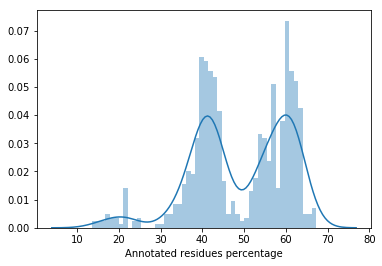

In [75]:
plot=sns.distplot(list_percent_annotate,bins=50,axlabel="Annotated residues percentage")
plot.figure.savefig("/Users/chilpert/Work/NOX_visu/annotated_part.pdf")

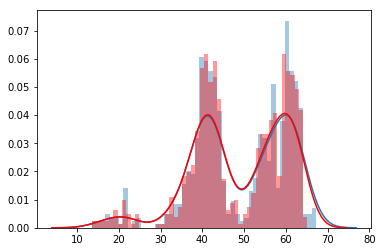

In [91]:
plot=sns.distplot(list_percent_annotate,bins=50)
sns.distplot(list_core_annotate,bins=50,color="red")
plot.figure.savefig("/Users/chilpert/Work/NOX_visu/annotated_part_withCore.pdf")

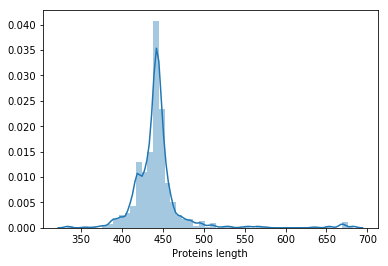

In [95]:
sns.distplot(list_length,axlabel="Proteins length").figure.savefig("/Users/chilpert/Work/NOX_visu/proteins_length_distrib.pdf")